This is my capstone project for the Udacity Machine Learning Nanodegree.

In [1]:
import pandas as pd
import numpy as np
import keras as kr
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


In [22]:
directory = 'sandp500/individual_stocks_5yr'
dir_listing = listdir(directory)

symbols_list = []

for symbol in dir_listing:
    symb = symbol.split('_')[0]
    symbols_list.append(symb)

print(len(symbols_list))
print(symbols_list[0])

504
AAL


In [23]:
csv_file = '{}/{}_data.csv'.format(directory, symbols_list[0])

In [24]:
df = pd.read_csv(csv_file)
df = df.drop('Name', 1)

In [25]:
df.set_index('Date', inplace=True)

In [26]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2013-12-09,23.85,25.44,23.45,24.60,43197268
2013-12-10,24.50,25.17,24.41,24.88,18660625
2013-12-11,25.48,27.20,25.37,25.99,38843371
2013-12-12,26.20,26.71,25.45,25.45,19981824
2013-12-13,25.75,26.30,25.52,26.23,12192421
2013-12-16,26.63,26.77,26.35,26.61,13190945
2013-12-17,26.48,26.59,25.95,26.10,11413199
2013-12-18,25.99,26.23,25.55,26.23,9994162
2013-12-19,26.12,26.49,25.82,26.12,6916497


This code is for comparing the different columns of the raw data. 

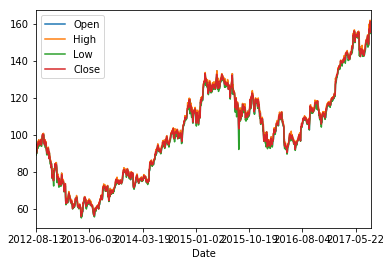

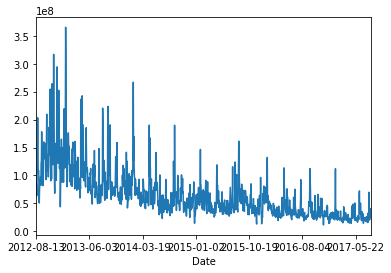

In [7]:
df[['Open', 'High', 'Low', 'Close']].plot()
plt.show()
df['Volume'].plot()
plt.show()

The following is graphing a few of the graphs with the opening price and the volume on one graph to compare with two different axis'.  I thought to do this as a comparison between the opening price (which all the raw data features follow roughly the same line) and the volume feature.  Since the volume feature is important. [http://www.investopedia.com/terms/v/volume.asp]

In [29]:
def getting_preprocessed_data(symbol):
        csv_file = '{}/{}_data.csv'.format(directory, symbol)
        df = pd.read_csv(csv_file)
        df = df.drop('Name', 1)
        df.set_index('Date', inplace=True)
        # below was found at https://stackoverflow.com/questions/29314033/python-pandas-dataframe-remove-empty-cells
        df['Open'].replace('', np.nan, inplace=True)
        df.dropna(subset=['Open'], inplace=True)
        return df


def plotting_stocks(symbols_list, amount_of_stocks=0):
    if amount_of_stocks == 0:
        amount_of_stocks = len(symbols_list)
        
    for symbol in symbols_list[:amount_of_stocks]:
        fig, ax = plt.subplots()
        fig.subplots_adjust(right=0.7)
        df = getting_preprocessed_data(symbol)
        print(symbol)
        df.Open.plot(ax=ax, style='b-', figsize=(20,10))
        # same ax as above since it's automatically added on the right
        df.Volume.plot(ax=ax, style='r-', secondary_y=True, figsize=(20,10))
        # add legend --> take advantage of pandas providing us access
        # to the line associated with the right part of the axis
        #ax.legend([ax.get_lines()[0], ax.get_lines()[0]], ['Open','Volume'], bbox_to_anchor=(1.5, 0.5))
        plt.show()

AAL


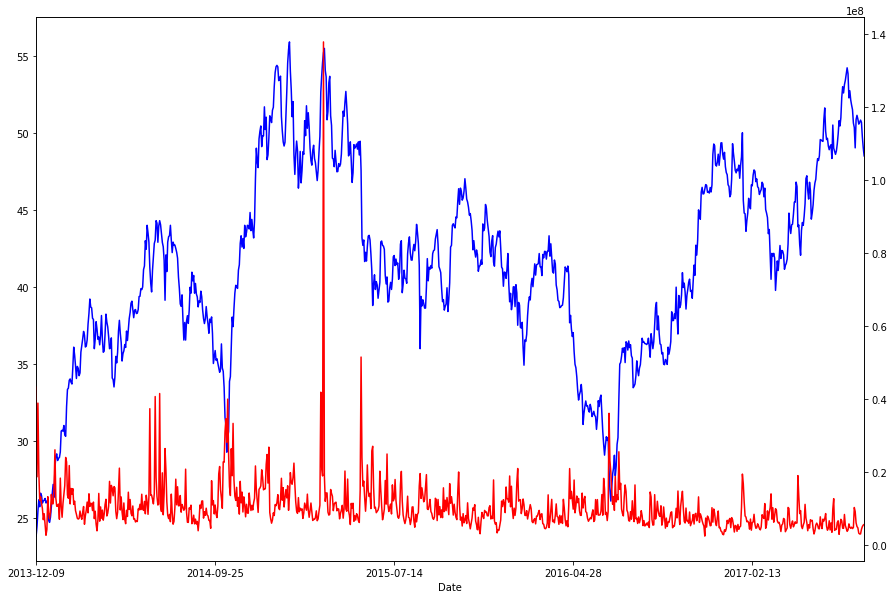

In [30]:
# printing out the first four stocks to get an idea of how each stock is individually represented.
plotting_stocks(symbols_list, 1)

In [33]:
#below is the Daily Returns calculation to put into the Sharpe Ratio. 
df = df.assign(Daily_Returns = np.divide((df.Open - df.Close), df.Close) * 100)

In [35]:
#Below is the calculation for the Sharpe Ratio column. 
df = df.assign(Sharpe_Ratio = np.divide((df.Daily_Returns - 0.046), np.std(np.array([df.Open, df.High, df.Close, df.Close]))))

In [37]:
#Below is the rate of change for the specific stock. 
df = df.assign(Rate_of_Change = (np.divide(df.Close, df.Open) - 1) * 100)

In [38]:
df1

,Open,High,Low,Close,Volume,Daily_Returns,Sharpe_Ratio,Rate_of_Change
Date,,,,,,,,
2013-12-09,23.85,25.44,23.45,24.60,43197268,-3.048780,-0.491152,3.144654
2013-12-10,24.50,25.17,24.41,24.88,18660625,-1.527331,-0.249693,1.551020
2013-12-11,25.48,27.20,25.37,25.99,38843371,-1.962293,-0.318723,2.001570
2013-12-12,26.20,26.71,25.45,25.45,19981824,2.946955,0.460391,-2.862595
2013-12-13,25.75,26.30,25.52,26.23,12192421,-1.829966,-0.297722,1.864078
2013-12-16,26.63,26.77,26.35,26.61,13190945,0.075160,0.004628,-0.075103
2013-12-17,26.48,26.59,25.95,26.10,11413199,1.455939,0.223762,-1.435045
2013-12-18,25.99,26.23,25.55,26.23,9994162,-0.914983,-0.152511,0.923432
2013-12-19,26.12,26.49,25.82,26.12,6916497,0.000000,-0.007300,0.000000
